In [1]:
import pyspark as ps

In [2]:
from pyspark.sql.types import *

In [3]:
from pyspark.sql import functions as func
from pyspark.sql.window import Window

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [5]:
import requests 
import pprint
import json

In [106]:
import scipy.stats as stats

In [6]:
## Retrieving a missing hero names and roles information from the API.

r = requests.get('https://api.opendota.com/api/heroes')
hero_list = json.loads(r.text)

## Saving the API info as a dataframe
hero_df = pd.DataFrame(hero_list)
hero_df.drop(['name','primary_attr','legs'],axis=1,inplace = True)

In [7]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[2]')
         .appName('capstone')
         .getOrCreate()
        )

In [8]:
samples_eda = spark.read.csv('players_larger_sample.csv',
                             header = True,
                             sep=',',
                             inferSchema=True)

In [9]:
samples_eda.cache()

DataFrame[match_id: bigint, account_id: bigint, player_slot: int, hero_id: int, item_0: int, item_1: int, item_2: int, item_3: int, item_4: int, item_5: int, kills: int, deaths: int, assists: int, leaver_status: int, gold: int, last_hits: int, denies: int, gold_per_min: int, xp_per_min: int, gold_spent: int, hero_damage: int, tower_damage: int, hero_healing: int, level: int, additional_units: string, stuns: string, max_hero_hit: string, times: string, gold_t: string, lh_t: string, xp_t: string, obs_log: string, sen_log: string, purchase_log: string, kills_log: string, buyback_log: string, lane_pos: string, obs: string, sen: string, actions: string, pings: string, purchase: string, gold_reasons: string, xp_reasons: string, killed: string, item_uses: string, ability_uses: string, hero_hits: string, damage: string, damage_taken: string, damage_inflictor: string, runes: string, killed_by: string, kill_streaks: string, multi_kills: string, life_state: string]

In [10]:
samples_eda.select([func.count(func.when(func.col(c).isNull(), c)).alias(c) for c in samples_eda.columns]).show()

+--------+----------+-----------+-------+------+------+------+------+------+------+-----+------+-------+-------------+-------+---------+------+------------+----------+----------+-----------+------------+------------+-----+----------------+-------+------------+-------+-------+-------+-------+-------+-------+------------+---------+-----------+--------+-------+-------+-------+-------+--------+------------+----------+-------+---------+------------+---------+-------+------------+----------------+-------+---------+------------+-----------+----------+
|match_id|account_id|player_slot|hero_id|item_0|item_1|item_2|item_3|item_4|item_5|kills|deaths|assists|leaver_status|   gold|last_hits|denies|gold_per_min|xp_per_min|gold_spent|hero_damage|tower_damage|hero_healing|level|additional_units|  stuns|max_hero_hit|  times| gold_t|   lh_t|   xp_t|obs_log|sen_log|purchase_log|kills_log|buyback_log|lane_pos|    obs|    sen|actions|  pings|purchase|gold_reasons|xp_reasons| killed|item_uses|ability_uses|h

In [11]:
df_players_samples_eda = samples_eda.select('hero_id','kills','deaths','assists','gold_per_min','xp_per_min')
df_players_samples_eda.show(5)

+-------+-----+------+-------+------------+----------+
|hero_id|kills|deaths|assists|gold_per_min|xp_per_min|
+-------+-----+------+-------+------------+----------+
|     14|   19|     8|      2|         338|       559|
|     32|    5|     2|      9|         280|       432|
|    100|    7|    19|     11|         357|       411|
|     76|    7|    10|     21|         438|       469|
|     86|   11|     5|     36|         500|       656|
+-------+-----+------+-------+------------+----------+
only showing top 5 rows



In [12]:
## Querying average stats by playable characters

df_players_samples_eda.createOrReplaceTempView("stats")
query = """
SELECT 
    hero_id,
    CAST((SUM(kills))/SUM(deaths) as decimal(5,2)) as kd_ratio,
    CAST((SUM(assists))/SUM(deaths) as decimal(5,2)) as ad_ratio,
    CAST(AVG(kills) as decimal(5,2)) as average_kills,
    CAST(AVG(assists) as decimal(5,2)) as average_assists,
    CAST(AVG(kills) + AVG(assists) as decimal(5,2)) as average_ka,
    CAST(AVG(deaths) as decimal(5,2)) as average_deaths,
    CAST(AVG(gold_per_min) as decimal(20,2)) as average_gold,
    CAST(AVG(xp_per_min) as decimal(5,2)) as average_xp,
    COUNT(hero_id) as freq
FROM stats s
GROUP BY hero_id
ORDER BY 
    freq DESC, 
    kd_ratio DESC
"""
#spark.sql(query).show(5)
eda_query = spark.sql(query)

In [13]:
eda_query.show(5)

+-------+--------+--------+-------------+---------------+----------+--------------+------------+----------+-----+
|hero_id|kd_ratio|ad_ratio|average_kills|average_assists|average_ka|average_deaths|average_gold|average_xp| freq|
+-------+--------+--------+-------------+---------------+----------+--------------+------------+----------+-----+
|     14|    1.27|    1.11|         9.32|           8.19|     17.52|          7.35|      898.39|    558.89|35634|
|     35|    1.06|    1.13|         7.16|           7.64|     14.80|          6.74|      952.12|    558.24|30918|
|      6|    0.86|    0.86|         6.21|           6.18|     12.39|          7.22|      943.95|    557.62|28480|
|     32|    1.57|    1.12|         9.67|           6.89|     16.56|          6.15|      712.82|    550.17|24722|
|     44|    0.91|    0.96|         6.48|           6.79|     13.28|          7.09|     1094.69|    595.91|24605|
+-------+--------+--------+-------------+---------------+----------+--------------+-----

In [14]:
eda_query.select([func.count(func.when(func.col(c).isNull(), c)).alias(c) for c in eda_query.columns]).show()

+-------+--------+--------+-------------+---------------+----------+--------------+------------+----------+----+
|hero_id|kd_ratio|ad_ratio|average_kills|average_assists|average_ka|average_deaths|average_gold|average_xp|freq|
+-------+--------+--------+-------------+---------------+----------+--------------+------------+----------+----+
|      0|       1|       1|            0|              0|         0|             0|           0|         0|   0|
+-------+--------+--------+-------------+---------------+----------+--------------+------------+----------+----+



In [15]:
## adding a percentage column for characters

eda_query = eda_query.withColumn('percent',func.col('freq')/func.sum('freq').over(Window.partitionBy()))
#eda_query.show()

In [16]:
eda_query.show(5)

+-------+--------+--------+-------------+---------------+----------+--------------+------------+----------+-----+--------------------+
|hero_id|kd_ratio|ad_ratio|average_kills|average_assists|average_ka|average_deaths|average_gold|average_xp| freq|             percent|
+-------+--------+--------+-------------+---------------+----------+--------------+------------+----------+-----+--------------------+
|     14|    1.27|    1.11|         9.32|           8.19|     17.52|          7.35|      898.39|    558.89|35634|0.031289815838438685|
|     35|    1.06|    1.13|         7.16|           7.64|     14.80|          6.74|      952.12|    558.24|30918| 0.02714874911861838|
|      6|    0.86|    0.86|         6.21|           6.18|     12.39|          7.22|      943.95|    557.62|28480|0.025007968655742657|
|     32|    1.57|    1.12|         9.67|           6.89|     16.56|          6.15|      712.82|    550.17|24722| 0.02170811099393504|
|     44|    0.91|    0.96|         6.48|           6.7

In [17]:
## exporting the mean values to pandas 
pd_eda = eda_query.toPandas()

In [18]:
pd_eda['percent'] = pd_eda['percent'].apply(lambda x: f'{float(x):.3f}')

In [19]:
pd_eda.head()

,hero_id,kd_ratio,ad_ratio,average_kills,average_assists,average_ka,average_deaths,average_gold,average_xp,freq,percent
0,14,1.27,1.11,9.32,8.19,17.52,7.35,898.39,558.89,35634,0.031
1,35,1.06,1.13,7.16,7.64,14.80,6.74,952.12,558.24,30918,0.027
2,6,0.86,0.86,6.21,6.18,12.39,7.22,943.95,557.62,28480,0.025
3,32,1.57,1.12,9.67,6.89,16.56,6.15,712.82,550.17,24722,0.022
4,44,0.91,0.96,6.48,6.79,13.28,7.09,1094.69,595.91,24605,0.022


In [20]:
pd_eda.isna().sum()

hero_id            0
kd_ratio           1
ad_ratio           1
average_kills      0
average_assists    0
average_ka         0
average_deaths     0
average_gold       0
average_xp         0
freq               0
percent            0
dtype: int64

In [21]:
## Looking for a row with null values
pd_eda[pd_eda.isnull().any(axis=1)]

,hero_id,kd_ratio,ad_ratio,average_kills,average_assists,average_ka,average_deaths,average_gold,average_xp,freq,percent
60,0,None,None,0.00,0.00,0.00,0.00,331.51,0.08,8208,0.007


In [22]:
hero_df.head(1)

,id,localized_name,attack_type,roles
0,1,Anti-Mage,Melee,"[Carry, Escape, Nuker]"


In [23]:
## Removing the hero_id: 0, since this id is not available from the dataframe I pulled from the API

pd_eda.drop(index=60,inplace = True)

In [24]:
## Resetting the index

pd_eda.reset_index(drop = True, inplace = True)

In [25]:
## Separating the roles

df_chars = pd.merge(pd_eda,
                        hero_df,
                        left_on = 'hero_id',
                        right_on = 'id',
                        how = 'inner')\
                            .drop('id',axis=1)

In [26]:
## Taking a look at the data type for future computation
df_chars.dtypes

hero_id             int32
kd_ratio           object
ad_ratio           object
average_kills      object
average_assists    object
average_ka         object
average_deaths     object
average_gold       object
average_xp         object
freq                int64
percent            object
localized_name     object
attack_type        object
roles              object
dtype: object

In [27]:
df_chars.columns

Index(['hero_id', 'kd_ratio', 'ad_ratio', 'average_kills', 'average_assists',
       'average_ka', 'average_deaths', 'average_gold', 'average_xp', 'freq',
       'percent', 'localized_name', 'attack_type', 'roles'],
      dtype='object')

In [28]:
## converting a number of object columns into numeric columns
cols = ['kd_ratio', 'ad_ratio', 'average_kills', 'average_deaths','average_assists', 
        'average_ka','average_gold', 'average_xp', 'freq', 'percent']

df_chars[cols] = df_chars[cols].apply(pd.to_numeric, errors = 'coerce')


## Rearranging columns for better legibility
cols_re = ['hero_id','localized_name','average_kills','average_assists','average_ka',
           'average_deaths','kd_ratio','ad_ratio','average_gold','average_xp','freq','percent']

df_chars = df_chars[cols_re]

df_chars['popularity'] = df_chars['freq'].rank(ascending = False)

In [29]:
df_chars.head(5)

,hero_id,localized_name,average_kills,average_assists,average_ka,average_deaths,kd_ratio,ad_ratio,average_gold,average_xp,freq,percent,popularity
0,14,Pudge,9.32,8.19,17.52,7.35,1.27,1.11,898.39,558.89,35634,0.031,1.0
1,35,Sniper,7.16,7.64,14.80,6.74,1.06,1.13,952.12,558.24,30918,0.027,2.0
2,6,Drow Ranger,6.21,6.18,12.39,7.22,0.86,0.86,943.95,557.62,28480,0.025,3.0
3,32,Riki,9.67,6.89,16.56,6.15,1.57,1.12,712.82,550.17,24722,0.022,4.0
4,44,Phantom Assassin,6.48,6.79,13.28,7.09,0.91,0.96,1094.69,595.91,24605,0.022,5.0


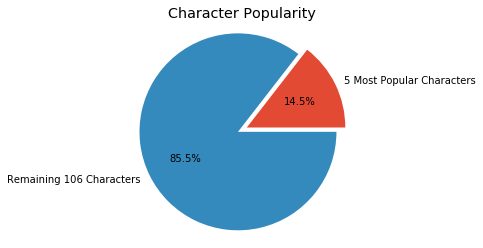

In [30]:
fig,ax = plt.subplots()

labels = ['5 Most Popular Characters', 'Remaining 106 Characters']
explode = (0.1,0)
sizes = [0.38, 0.62]

ax.pie([df_chars.loc[:5]['percent'].sum(), df_chars.loc[5:]['percent'].sum()],
      explode = explode,
      labels = labels,
      startangle = 0,
      autopct = '%1.1f%%')

ax.axis('equal')
ax.set_title('Character Popularity')
plt.show()

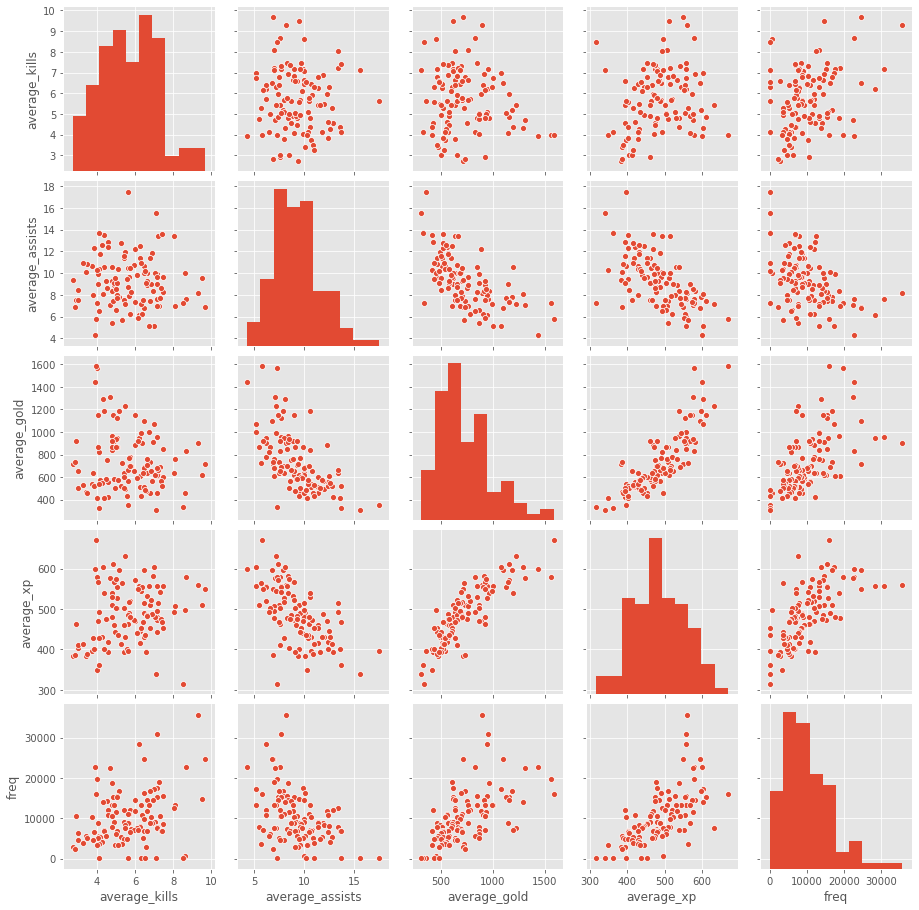

In [31]:
sns.pairplot(df_chars, vars = ['average_kills','average_assists','average_gold','average_xp','freq'])
plt.show()

In [32]:
df_chars.sort_values(by='average_kills',ascending = False).head(5)

,hero_id,localized_name,average_kills,average_assists,average_ka,average_deaths,kd_ratio,ad_ratio,average_gold,average_xp,freq,percent,popularity
3,32,Riki,9.67,6.89,16.56,6.15,1.57,1.12,712.82,550.17,24722,0.022,4.0
22,47,Viper,9.50,9.50,19.00,6.52,1.46,1.46,617.34,510.48,14701,0.013,23.0
0,14,Pudge,9.32,8.19,17.52,7.35,1.27,1.11,898.39,558.89,35634,0.031,1.0
5,4,Bloodseeker,8.67,7.59,16.26,7.28,1.19,1.04,831.63,580.13,22734,0.020,6.0
104,104,Legion Commander,8.60,10.01,18.61,8.17,1.05,1.23,455.17,496.70,560,0.000,105.0


In [33]:
df_chars.sort_values(by='average_deaths').head(5)

,hero_id,localized_name,average_kills,average_assists,average_ka,average_deaths,kd_ratio,ad_ratio,average_gold,average_xp,freq,percent,popularity
40,12,Phantom Lancer,5.67,7.93,13.60,4.99,1.14,1.59,702.05,517.28,10991,0.010,41.0
19,42,Wraith King,4.84,7.40,12.24,5.08,0.95,1.46,1154.29,612.47,15360,0.013,20.0
84,94,Medusa,4.49,9.23,13.72,5.72,0.79,1.61,581.45,474.54,5615,0.005,85.0
82,80,Lone Druid,4.11,6.48,10.60,5.72,0.72,1.13,823.68,493.21,5710,0.005,83.0
23,63,Weaver,6.95,8.37,15.32,5.90,1.18,1.42,910.25,582.56,14622,0.013,24.0


In [34]:
df_chars.sort_values(by = 'average_assists',ascending = False).head(5)

,hero_id,localized_name,average_kills,average_assists,average_ka,average_deaths,kd_ratio,ad_ratio,average_gold,average_xp,freq,percent,popularity
106,110,Phoenix,5.62,17.48,23.11,8.30,0.68,2.11,353.34,395.89,122,0.000,107.0
108,111,Oracle,7.10,15.56,22.65,8.04,0.88,1.93,312.06,338.65,72,0.000,109.0
107,112,Winter Wyvern,4.13,13.68,17.81,7.69,0.54,1.78,324.90,360.79,77,0.000,108.0
77,36,Necrophos,7.40,13.61,21.02,6.76,1.09,2.01,520.63,467.87,6734,0.006,78.0
76,29,Tidehunter,4.37,13.54,17.91,6.78,0.64,2.00,410.63,401.37,6790,0.006,77.0


In [35]:
df_chars.sort_values(by = 'average_gold',ascending = False).head(5)

,hero_id,localized_name,average_kills,average_assists,average_ka,average_deaths,kd_ratio,ad_ratio,average_gold,average_xp,freq,percent,popularity
16,95,Troll Warlord,3.96,5.74,9.70,7.23,0.55,0.79,1584.43,669.90,15922,0.014,17.0
8,27,Shadow Shaman,3.99,7.23,11.22,7.68,0.52,0.94,1564.45,578.45,19695,0.017,9.0
6,1,Anti-Mage,3.92,4.29,8.21,6.31,0.62,0.68,1438.95,600.10,22635,0.020,7.0
7,26,Lion,4.69,7.06,11.75,7.45,0.63,0.95,1308.33,576.96,22534,0.020,8.0
27,102,Abaddon,4.34,8.06,12.40,6.24,0.69,1.29,1292.48,603.77,13908,0.012,28.0


In [36]:
df_chars.sort_values(by = 'average_xp',ascending = False).head(5)

,hero_id,localized_name,average_kills,average_assists,average_ka,average_deaths,kd_ratio,ad_ratio,average_gold,average_xp,freq,percent,popularity
16,95,Troll Warlord,3.96,5.74,9.70,7.23,0.55,0.79,1584.43,669.90,15922,0.014,17.0
66,34,Tinker,5.45,7.17,12.62,7.39,0.74,0.97,1226.62,632.36,7634,0.007,67.0
19,42,Wraith King,4.84,7.40,12.24,5.08,0.95,1.46,1154.29,612.47,15360,0.013,20.0
27,102,Abaddon,4.34,8.06,12.40,6.24,0.69,1.29,1292.48,603.77,13908,0.012,28.0
12,70,Ursa,6.98,5.14,12.12,6.91,1.01,0.74,1074.54,603.26,17308,0.015,13.0


In [38]:
## Using the sample data to plot distributions
df_full = df_players_samples_eda.toPandas()

In [39]:
top5_ids = df_chars.iloc[:5]['hero_id']


In [107]:
df_top5 = df_full[df_full['hero_id'].isin(top5_ids)]
df_rest = df_full[~df_full['hero_id'].isin(top5_ids)]

In [64]:
df_top5.describe()

,hero_id,kills,deaths,assists,gold_per_min,xp_per_min
count,144359.000000,144359.000000,144359.000000,144359.000000,144359.000000,144359.000000
mean,25.115234,7.820926,6.945476,7.214396,920.564717,563.317819
std,13.871377,9.381611,4.438477,6.592025,889.883984,286.585643
min,6.000000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,14.000000,3.000000,4.000000,3.000000,316.000000,376.000000
50%,32.000000,6.000000,7.000000,6.000000,448.000000,526.000000
75%,35.000000,10.000000,9.000000,10.000000,1426.000000,693.000000
max,44.000000,128.000000,128.000000,128.000000,2500.000000,2500.000000


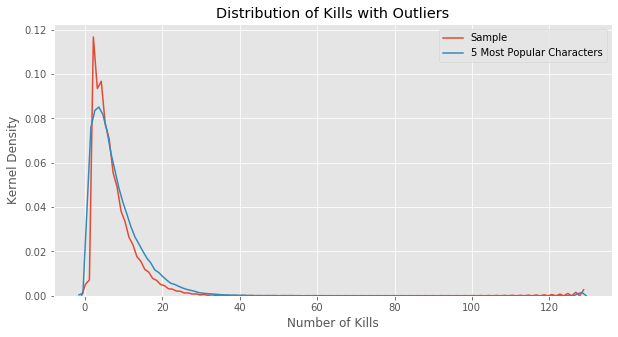

In [71]:
fig,ax = plt.subplots(figsize = (10,5))

ax = sns.kdeplot(df_full['kills'])

# Plotting a top 5 character's kills distribution
sns.kdeplot(df_full[df_full['hero_id'].isin(top5_ids)]['kills']) 

ax.set_title('Distribution of Kills with Outliers')

ax.set_xlabel('Number of Kills')

ax.set_ylabel('Kernel Density')

ax.legend(['Sample','5 Most Popular Characters'])

#ax.axvline(df_full['kills'].mean(),c='grey')  ## mean of the sample kills


ax.axvline
plt.show()

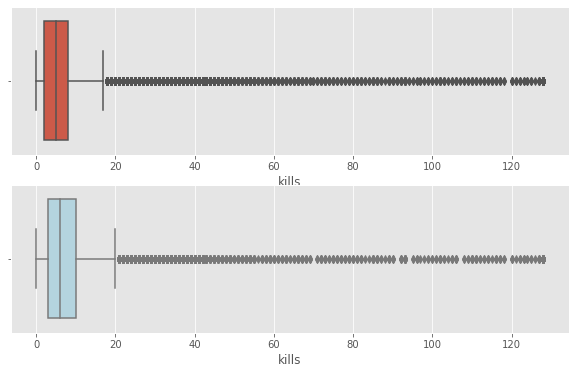

In [42]:
fig,axs = plt.subplots(2,1,figsize=(10,6))

sns.boxplot(df_full['kills'], ax = axs[0]) ## sample

sns.boxplot(df_full[df_full['hero_id'].isin(top5_ids)]['kills'], ax = axs[1],color = 'lightblue')  ## top-5

plt.show()

In [43]:
## Removing outliers for the kills column.


In [44]:
def subset_by_iqr(df,col):
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    filt_condition = (df[col] >= q1 - 1.5 * iqr) & (df[col] <= q3 + 1.5 * iqr)
    
    return df[filt_condition][col]

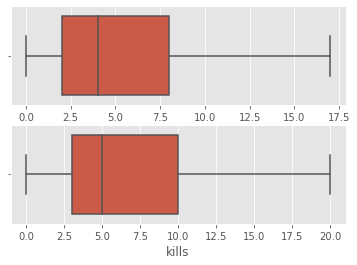

In [133]:
plt,axs = plt.subplots(2,1)
sns.boxplot(subset_by_iqr(df_full,'kills'),ax = axs[0])
sns.boxplot(subset_by_iqr(df_top5,'kills'), ax = axs[1])
plt.show()

In [90]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

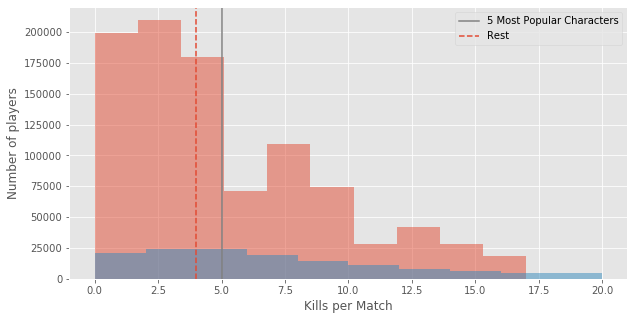

<Figure size 432x288 with 0 Axes>

In [156]:
fig,ax = plt.subplots(figsize=(10,5))

ax.hist(subset_by_iqr(df_rest,'kills'), alpha = 0.5)

ax.hist(subset_by_iqr(df_top5,'kills'), alpha = 0.5)

ax.axvline(subset_by_iqr(df_top5,'kills').quantile(.5),c='gray')

ax.axvline(subset_by_iqr(df_rest,'kills').quantile(.5),linestyle='--')

ax.legend(['5 Most Popular Characters', 'Rest'])

ax.set_xlabel('Kills per Match')

ax.set_ylabel('Number of players')

plt.show()
plt.savefig('kills_histogram.png')

In [125]:
subset_by_iqr(df_rest,'kills').describe()

count    961193.000000
mean          5.113767
std           4.095987
min           0.000000
25%           2.000000
50%           4.000000
75%           8.000000
max          17.000000
Name: kills, dtype: float64

In [126]:
subset_by_iqr(df_top5,'kills').describe()

count    137380.000000
mean          6.522478
std           4.925248
min           0.000000
25%           3.000000
50%           5.000000
75%          10.000000
max          20.000000
Name: kills, dtype: float64

In [140]:
import numpy as np
import scipy.stats as stats
stats,pval = stats.ttest_ind(df_full['kills'],df_top5['kills'],equal_var=False)
print(pval)

0.0


In [115]:
# Performing a non-parametric test: Mann-Whitney Signed Rank Test for feature: kills

res = stats.mannwhitneyu(df_top5['kills'],df_rest['kills'],alternative = 'greater')
res

MannwhitneyuResult(statistic=83408972475.5, pvalue=0.0)

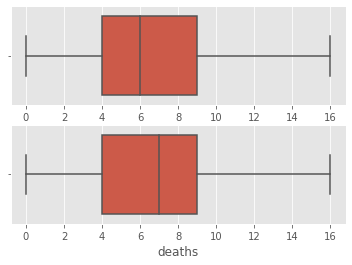

In [92]:
plt,axs = plt.subplots(2,1)
sns.boxplot(subset_by_iqr(df_full,'deaths'),ax = axs[0])
sns.boxplot(subset_by_iqr(df_top5,'deaths'), ax = axs[1])
plt.show()

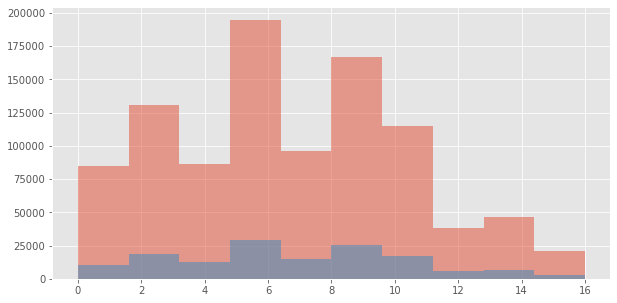

In [119]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

fig,ax = plt.subplots(figsize=(10,5))

ax.hist(subset_by_iqr(df_rest,'deaths'),alpha = 0.5)

ax.hist(subset_by_iqr(df_top5,'deaths'),alpha = 0.5)
plt.show()

In [121]:
# Performing a non-parametric test: Mann-Whitney Signed Rank Test for feature: deaths

res = stats.mannwhitneyu(df_top5['deaths'],df_rest['deaths'],alternative = 'greater')
res

MannwhitneyuResult(statistic=73127320488.5, pvalue=2.951321989356567e-31)

In [154]:
stats,pval = stats.ttest_ind(df_rest['deaths'],df_top5['deaths'],equal_var=False)
print(pval)

1.9616701166961974e-06


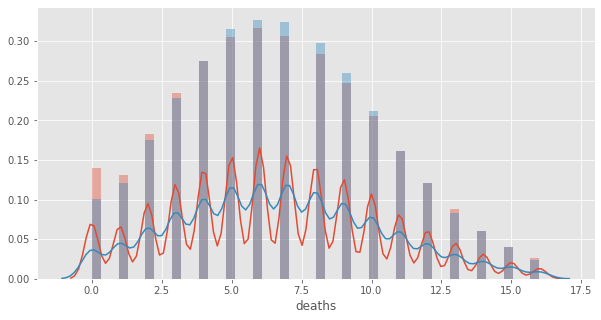

In [153]:
fig,ax = plt.subplots(figsize=(10,5))

ax = sns.distplot(subset_by_iqr(df_rest,'deaths'))

sns.distplot(subset_by_iqr(df_top5,'deaths'))
plt.show()

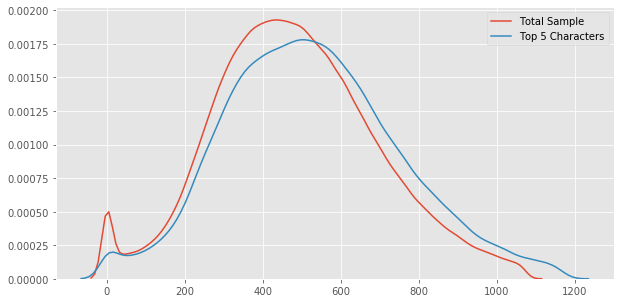

In [142]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
fig,ax = plt.subplots(figsize = (10,5))

ax = sns.kdeplot(subset_by_iqr(df_full,'xp_per_min'))

# Plotting a top 5 character's kills distribution
sns.kdeplot(subset_by_iqr(df_top5,'xp_per_min')) 

ax.legend(['Total Sample','Top 5 Characters'])
plt.show()

In [270]:
hyp_test_info

,summary,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent
0,count,112,111,111,112,112,112,97,112,112,112
1,mean,56.330357142857146,0.817748,1.322072,5.647679,6.959643,9.170089,650.650000,481.850536,10168.1875,0.008928571428571433
2,stddev,32.844264899800045,0.2225296085904676,0.31625684934621523,1.5916091818171911,0.9941558314700052,2.4816495878026226,172.18989960215444,83.32312163925705,6598.429643280271,0.0057940070820321704
3,min,0,0.35,0.68,0.00,0.00,0.00,312.06,0.08,60,5.268532722417695E-5
4,max,113,1.57,2.13,9.67,9.97,17.48,987.94,669.90,35634,0.031289815838438685


In [ ]:
sns.distplot()

Null Hypothesis ${H_0}$: Players do not choose a character to maximize their kill counts.


Alternate Hypothesis $H_A$: Players choose a character over another in order to maximize their kill counts.

In [130]:
## IF I have enough Time, perform a deeper EDA with roles, rather than characters, and perform a hypothesis test

In [ ]:
## converting the pandas dataframe into a spark dataframe
spark_hero = spark.createDataFrame(hero_df)

## Performing a lateral view explode on the roles column
spark_hero.createOrReplaceTempView("roles")

query = """
SELECT id, localized_name, role
from roles
lateral view explode(roles) as role
"""
spark_hero_df = spark.sql(query)

## renaming the id column into hero_id
spark_hero_df = spark_hero_df.withColumnRenamed('id','hero_id')

spark_hero_df.show(5)

In [129]:
## Joining a datafreme extracted from a .csv file with a dataframe extracted from API

df_raw = df_players_samples_eda.join(spark_hero_df, 'hero_id')

df_raw.cache()

df_raw.createOrReplaceTempView('rawData')

query = """
SELECT 
    role,
    SUM(kills) as total_kills,
    CAST(SUM(kills) / COUNT(*) as DECIMAL(5,2)) as avg_kills,
    SUM(deaths) as total_deaths,
    CAST(SUM(deaths) / COUNT(*) as DECIMAL(5,2)) as avg_deaths,
    SUM(gold_per_min) as gold_m,
    CAST(SUM(gold_per_min) / COUNT(*) as DECIMAL(10,2)) as avg_gold_m,
    SUM(xp_per_min) as xp_m,
    CAST(SUM(xp_per_min) / COUNT(*) as DECIMAL(10,2)) as avg_xp_m,
    COUNT(role) as freq

FROM rawData

GROUP BY role
    
ORDER BY freq DESC
"""
spark.sql(query).show(20)

+---------+-----------+---------+------------+----------+---------+----------+---------+--------+------+
|     role|total_kills|avg_kills|total_deaths|avg_deaths|   gold_m|avg_gold_m|     xp_m|avg_xp_m|  freq|
+---------+-----------+---------+------------+----------+---------+----------+---------+--------+------+
| Disabler|    4635831|     5.93|     5500317|      7.03|631044626|    806.58|396693903|  507.04|782372|
|    Nuker|    4480191|     5.87|     5378818|      7.04|617853267|    809.24|385662592|  505.13|763497|
|    Carry|    4548094|     6.25|     4934375|      6.78|637626189|    875.63|392307205|  538.74|728190|
|Initiator|    2984178|     5.92|     3605219|      7.15|414653532|    822.61|256300791|  508.46|504070|
|   Escape|    2747610|     5.92|     3125919|      6.74|393801919|    848.75|243619149|  525.06|463981|
|  Durable|    2579031|     6.06|     2948227|      6.93|341572853|    803.13|218903906|  514.70|425300|
|  Support|    1662131|     5.00|     2312740|      6.9